# Load Dataset

In [3]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics.pairwise import cosine_similarity
from typing import List

In [4]:
data_path = './anime/'

# Read the dataset
animes = pd.read_csv(data_path+'anime.csv')
ratings = pd.read_csv(data_path+'rating.csv')

In [5]:
display(animes.sample(10))

,anime_id,name,genre,type,episodes,rating,members
11912,10325,Kyuuketsuki,"Hentai, Vampire",OVA,2,5.91,3281
11509,4714,The Rapeman,Hentai,OVA,2,6.50,2722
8766,30861,Happy Bogeys,NaN,Movie,12,8.17,38
9752,31034,Nintama Rantarou: Ninjutsu Gakuen to Nazo no O...,Comedy,Special,1,6.67,104
9548,16954,Milky Passion: Dougenzaka - Ai no Shiro,"Josei, Romance",OVA,1,5.47,196
7372,30428,Hikenai Guitar wo Hikundaze,Music,Music,1,5.49,217
11085,34086,Tales of Zestiria the X (2017),"Action, Adventure, Fantasy",TV,12,NaN,10848
8584,29653,Futari Zamurai Homare no Kawakiri,"Drama, Historical, Samurai",Movie,1,4.82,97
2223,11783,Dog Days&#039;,"Action, Adventure, Fantasy, Magic",TV,13,7.32,55277
8280,32760,Bungaku Shounen no Yuuutsu,"Drama, Music",Music,1,6.30,37


In [6]:
display(ratings.sample(10))

,user_id,anime_id,rating
1943855,18869,18153,8
2372031,22723,18897,-1
1748026,16957,1691,9
5042787,48252,10030,10
395220,4078,288,-1
6108530,57342,15225,-1
7233931,67443,21327,8
3023115,28051,371,-1
926020,8352,177,8
442341,4537,2001,8


# Preprocessing & Feature Engineering

In [7]:
# 사용하는 피처만 남김
animes = animes[['anime_id', 'type', 'rating', 'members', 'name', 'genre']]
# 칼럼명 변경
animes.columns = ['anime_id', 'type', 'anime_total_rating', 'members', 'name', 'genre']
# 결측값이 포함된 애니는 drop
animes = animes.dropna()

In [8]:
# 평점 테이블도 동일하게 처리, 무효한 값은 제거 (rating이 -1인 값)
ratings = ratings[['user_id', 'anime_id', 'rating']]
ratings = ratings[ratings['rating'] != -1]

In [10]:
# 데이터 프레임 join
data = ratings.merge(animes, on='anime_id', how='inner')

# 유저 정보가 없으므로, 유저의 평점 패턴에서 유저 피처 추출 (평균 평점 및 평점을 내린 수)
user_avg_rating = data.groupby('user_id')['rating'].mean().rename('User-AvgRating')
user_num_ratings = data.groupby('user_id')['rating'].count().rename('User-NumRatings')

# 추출한 유저 피처 결합
user_features = pd.concat([user_avg_rating, user_num_ratings], axis=1)

# 애니 메타 데이터에서 아이템 관련 피처 수가 생성
item_num_ratings = data.groupby('anime_id')['rating'].count().rename('Item-NumRatings')

# 애니 이름 피처에서 TF-IDF 피처 생성, 총 10개의 이름 생성 (most frequent N words)
tfidf_vectorizer = TfidfVectorizer(max_features=20)
item_name_tfidf = tfidf_vectorizer.fit_transform(animes['name']).toarray()

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# 'type' 칼럼을 원핫 인코딩
onehot_encoder = OneHotEncoder(sparse_output=False)
item_type_onehot = onehot_encoder.fit_transform(animes[['type']])

# TF-IDF 피처와 type 원핫 피처를 결합
tf_idf_df = pd.DataFrame(item_name_tfidf, columns=tfidf_feature_names, index=animes.anime_id)
type_df = pd.DataFrame(item_type_onehot, columns=[f'Type-{cat}' for cat in onehot_encoder.categories_[0]], index=animes.anime_id)

animes_features = animes[['anime_id', 'members', 'anime_total_rating']]

In [11]:
item_features = pd.DataFrame(item_num_ratings)\
            .merge(tf_idf_df, on="anime_id")\
            .merge(type_df, on="anime_id")\
            .merge(animes_features.set_index('anime_id'), on="anime_id")

In [12]:
item_features.head()

,Item-NumRatings,039,animation,chan,ga,hen,kun,monogatari,movie,ni,...,wa,wo,Type-Movie,Type-Music,Type-ONA,Type-OVA,Type-Special,Type-TV,members,anime_total_rating
anime_id,,,,,,,,,,,,,,,,,,,,,
1,13449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,486824,8.82
5,5790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,137636,8.40
6,9385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,283069,8.32
7,2169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,64905,7.36
8,308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9848,7.06


In [32]:
item_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9892 entries, 1 to 34475
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Item-NumRatings     9892 non-null   int64  
 1   039                 9892 non-null   float64
 2   animation           9892 non-null   float64
 3   chan                9892 non-null   float64
 4   ga                  9892 non-null   float64
 5   hen                 9892 non-null   float64
 6   kun                 9892 non-null   float64
 7   monogatari          9892 non-null   float64
 8   movie               9892 non-null   float64
 9   ni                  9892 non-null   float64
 10  no                  9892 non-null   float64
 11  of                  9892 non-null   float64
 12  ova                 9892 non-null   float64
 13  san                 9892 non-null   float64
 14  shoujo              9892 non-null   float64
 15  special             9892 non-null   float64
 16  specials  

In [13]:
# 인터렉션 데이터와 함께, user 및 item 피처 결합
data = data.drop(['anime_total_rating', 'members'], axis=1)

data = data.join(user_features, on='user_id')
data = data.merge(item_features, on='anime_id')

# implicit feedback 표현을 위해 이진화 (유저의 평균 평점보다 높은 경우 1)
# 절대값으로 지정하는 방법도 있음
data['rating'] = (data['rating'] > data['User-AvgRating']).astype(int)

# Train-test split
X = data.drop(columns=['user_id','anime_id', 'rating', 'type', 'name', 'genre'])
y = data['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# 모델 정의
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'LGBM': LGBMClassifier(random_state=42)
}

In [15]:
X_train.head()

,User-AvgRating,User-NumRatings,Item-NumRatings,039,animation,chan,ga,hen,kun,monogatari,...,wa,wo,Type-Movie,Type-Music,Type-ONA,Type-OVA,Type-Special,Type-TV,members,anime_total_rating
1509263,8.080645,62,5259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,151561,8.53
6271372,8.814085,355,36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2718,7.65
1083815,8.647059,51,11399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,299278,7.14
2087798,7.522523,333,5697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,225927,8.50
2273893,8.625000,16,5318,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,117080,6.85


In [16]:
y_train.head()

1509263    1
6271372    1
1083815    0
2087798    1
2273893    1
Name: rating, dtype: int64

# 모델 학습

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

# 데이터셋 사이즈 지정
dataset_sizes = [1_000, 10_000, 100_000]

# 각 모델 별 auc score를 저장하기 위해 딕셔너리 정의
auc_scores = {model_name: [] for model_name in models.keys()}

# 각 모델 별 roc curve 정보 저장을 위해 딕셔너리 정의
roc_curves = {model_name: [] for model_name in models.keys()}

In [18]:
# ROC curve 그리기
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    # 대각선 추가
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)

In [19]:
# 데이터 사이즈별로 iteration
for size in dataset_sizes:
    # 각 사이즈별로 데이터를 샘플링함
    X_train_sample = X_train.sample(n=size, random_state=42)
    y_train_sample = y_train.loc[X_train_sample.index]

    # 모델 별로 반복
    for model_name, model in tqdm(models.items()):
        print(f"Training {model_name} with {size} samples...")
        
        # 모델 적합
        model.fit(X_train_sample, y_train_sample)

        # 예측 결과 생성
        y_pred = model.predict_proba(X_test)[:, 1]

        # AUC 점수 계산 
        auc_score = roc_auc_score(y_test, y_pred)
        auc_scores[model_name].append(auc_score)
        
        # ROC 곡선
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_curves[model_name].append((fpr, tpr))

        print(f"{model_name} AUC: {auc_score}")

  0%|          | 0/3 [00:00<?, ?it/s]

Training Decision Tree with 1000 samples...


 33%|███▎      | 1/3 [00:00<00:01,  1.52it/s]

Decision Tree AUC: 0.5805321574667675
Training Random Forest with 1000 samples...


 67%|██████▋   | 2/3 [00:10<00:05,  5.89s/it]

Random Forest AUC: 0.6704315091734973
Training LGBM with 1000 samples...
[LightGBM] [Info] Number of positive: 511, number of negative: 489
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1256
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511000 -> initscore=0.044007
[LightGBM] [Info] Start training from score 0.044007


100%|██████████| 3/3 [00:14<00:00,  4.73s/it]

LGBM AUC: 0.6610821588851576



  0%|          | 0/3 [00:00<?, ?it/s]

Training Decision Tree with 10000 samples...


 33%|███▎      | 1/3 [00:00<00:01,  1.54it/s]

Decision Tree AUC: 0.5901807706542092
Training Random Forest with 10000 samples...


 67%|██████▋   | 2/3 [00:17<00:10, 10.27s/it]

Random Forest AUC: 0.6900794819569178
Training LGBM with 10000 samples...
[LightGBM] [Info] Number of positive: 5238, number of negative: 4762
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1560
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523800 -> initscore=0.095272
[LightGBM] [Info] Start training from score 0.095272


100%|██████████| 3/3 [00:20<00:00,  6.76s/it]


LGBM AUC: 0.7335090849008683


  0%|          | 0/3 [00:00<?, ?it/s]

Training Decision Tree with 100000 samples...


 33%|███▎      | 1/3 [00:01<00:02,  1.46s/it]

Decision Tree AUC: 0.5926025274877159
Training Random Forest with 100000 samples...


 67%|██████▋   | 2/3 [00:36<00:21, 21.38s/it]

Random Forest AUC: 0.6943538713907167
Training LGBM with 100000 samples...
[LightGBM] [Info] Number of positive: 52619, number of negative: 47381
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1888
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.526190 -> initscore=0.104856
[LightGBM] [Info] Start training from score 0.104856


100%|██████████| 3/3 [00:39<00:00, 13.12s/it]

LGBM AUC: 0.7494487537251445


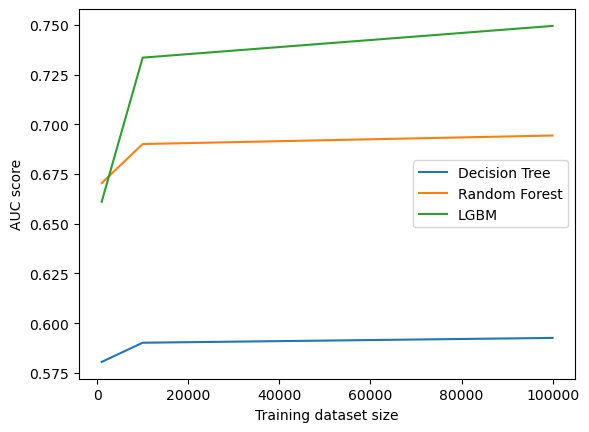

In [20]:
# AUC 스코어 시각화
for model_name, model_auc_scores in auc_scores.items():
    plt.plot(dataset_sizes, model_auc_scores, label=model_name)
plt.xlabel('Training dataset size')
plt.ylabel('AUC score')
plt.legend()
plt.show()

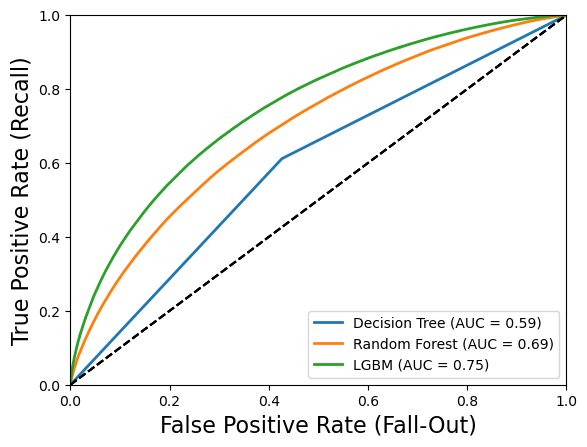

In [21]:
# 가장 큰 데이터셋에 대해서, ROC 커브 그리기
for model_name, model_roc_curves in roc_curves.items():
    fpr, tpr = model_roc_curves[-1]  # Select the ROC curve for the largest dataset size
    plot_roc_curve(fpr, tpr, label=f"{model_name} (AUC = {auc_scores[model_name][-1]:.2f})")
plt.legend()
plt.show()

# 실제 예측 값 확인

In [22]:
user_id = 20

In [23]:
user_data = data[data['user_id'] == user_id]
rated_animes = user_data['anime_id'].unique()
unrated_animes = item_features[~item_features.index.isin(rated_animes)]

In [24]:
# 유저 정보 붙여주기
user_features_df = user_features.loc[user_id]
unrated_animes = unrated_animes.assign(**user_features_df)

In [25]:
user_features_df.head()

User-AvgRating      9.578947
User-NumRatings    19.000000
Name: 20, dtype: float64

In [26]:
unrated_animes.assign(**user_features_df)

,Item-NumRatings,039,animation,chan,ga,hen,kun,monogatari,movie,ni,...,Type-Movie,Type-Music,Type-ONA,Type-OVA,Type-Special,Type-TV,members,anime_total_rating,User-AvgRating,User-NumRatings
anime_id,,,,,,,,,,,,,,,,,,,,,
1,13449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,486824,8.82,9.578947,19.0
5,5790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,137636,8.40,9.578947,19.0
6,9385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,283069,8.32,9.578947,19.0
7,2169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,64905,7.36,9.578947,19.0
8,308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,9848,7.06,9.578947,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34324,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,817,5.40,9.578947,19.0
34325,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1454,7.05,9.578947,19.0
34349,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1885,7.25,9.578947,19.0


In [27]:
def recommend_top_n(user_id, model, n=5):
    # 아직 유저가 평가하지 않은 애니 가져오기
    user_data = data[data['user_id'] == user_id]
    rated_animes = user_data['anime_id'].unique()
    unrated_animes = item_features[~item_features.index.isin(rated_animes)]
    
    # 유저 정보 붙여주기
    user_features_df = user_features.loc[user_id]
    unrated_animes = unrated_animes.assign(**user_features_df)

    # 해당 유저 대상으로 모델 예측
    unrated_animes['predicted_rating'] = model.predict_proba(unrated_animes)[:, 1]

    # 상위 N개의 평점 예측
    top_n_animes = unrated_animes.sort_values('predicted_rating', ascending=False).head(n)

    return top_n_animes

In [28]:
# 특정 유저에 대한 상위 n개 예측 생성
user_id = 26
top_n = recommend_top_n(user_id, models['LGBM'], n=5)[['predicted_rating']]

# top n개 예측의 상세 정보
top_n_details = top_n.merge(animes, how='left', left_index=True, right_on='anime_id')

print(f'Top 5 anime recommendations for user {user_id}:')
display(top_n_details)

Top 5 anime recommendations for user 26:


,predicted_rating,anime_id,type,anime_total_rating,members,name,genre
7904,0.306004,2778,OVA,4.70,573,Generation of Chaos III: Toki no Fuuin,"Action, Adventure, Fantasy, Magic"
3206,0.268808,2749,TV,7.05,428,Heisei Inu Monogatari Bow,"Adventure, Comedy"
5041,0.268808,7496,Movie,6.57,574,Saiyuuki: Son Gokuu Monogatari,Adventure
9041,0.259080,19627,OVA,5.73,162,Junkers Come Here: Memories of You,"Drama, Slice of Life"
4133,0.255129,29697,Special,6.80,813,Prince of Tennis: Message in a Bottle,"Comedy, School, Shounen, Sports"


In [29]:
# 좋은 평점을 준 애니 검색
user_ratings = ratings[ratings['user_id'] == user_id]
well_rated_animes = user_ratings[user_ratings['rating'] >= user_ratings['rating'].mean()]

# 상세 정보 조회
well_rated_details = animes[animes['anime_id'].isin(well_rated_animes['anime_id'])]

# 평점 정보를 포함한 좋은 평점 정보 출력
well_rated_details = well_rated_details.merge(well_rated_animes[['anime_id', 'rating']], on='anime_id', how='inner')


In [30]:
print(f'\nWell-rated animes by user {user_id}:')
display(well_rated_details)


Well-rated animes by user 26:


,anime_id,type,anime_total_rating,members,name,genre,rating
0,8525,TV,7.95,284846,Kami nomi zo Shiru Sekai,"Comedy, Harem, Romance, Shounen, Supernatural",10
1,10793,TV,7.81,460959,Guilty Crown,"Action, Drama, Sci-Fi, Super Power",10


# Feature Importance 플롯

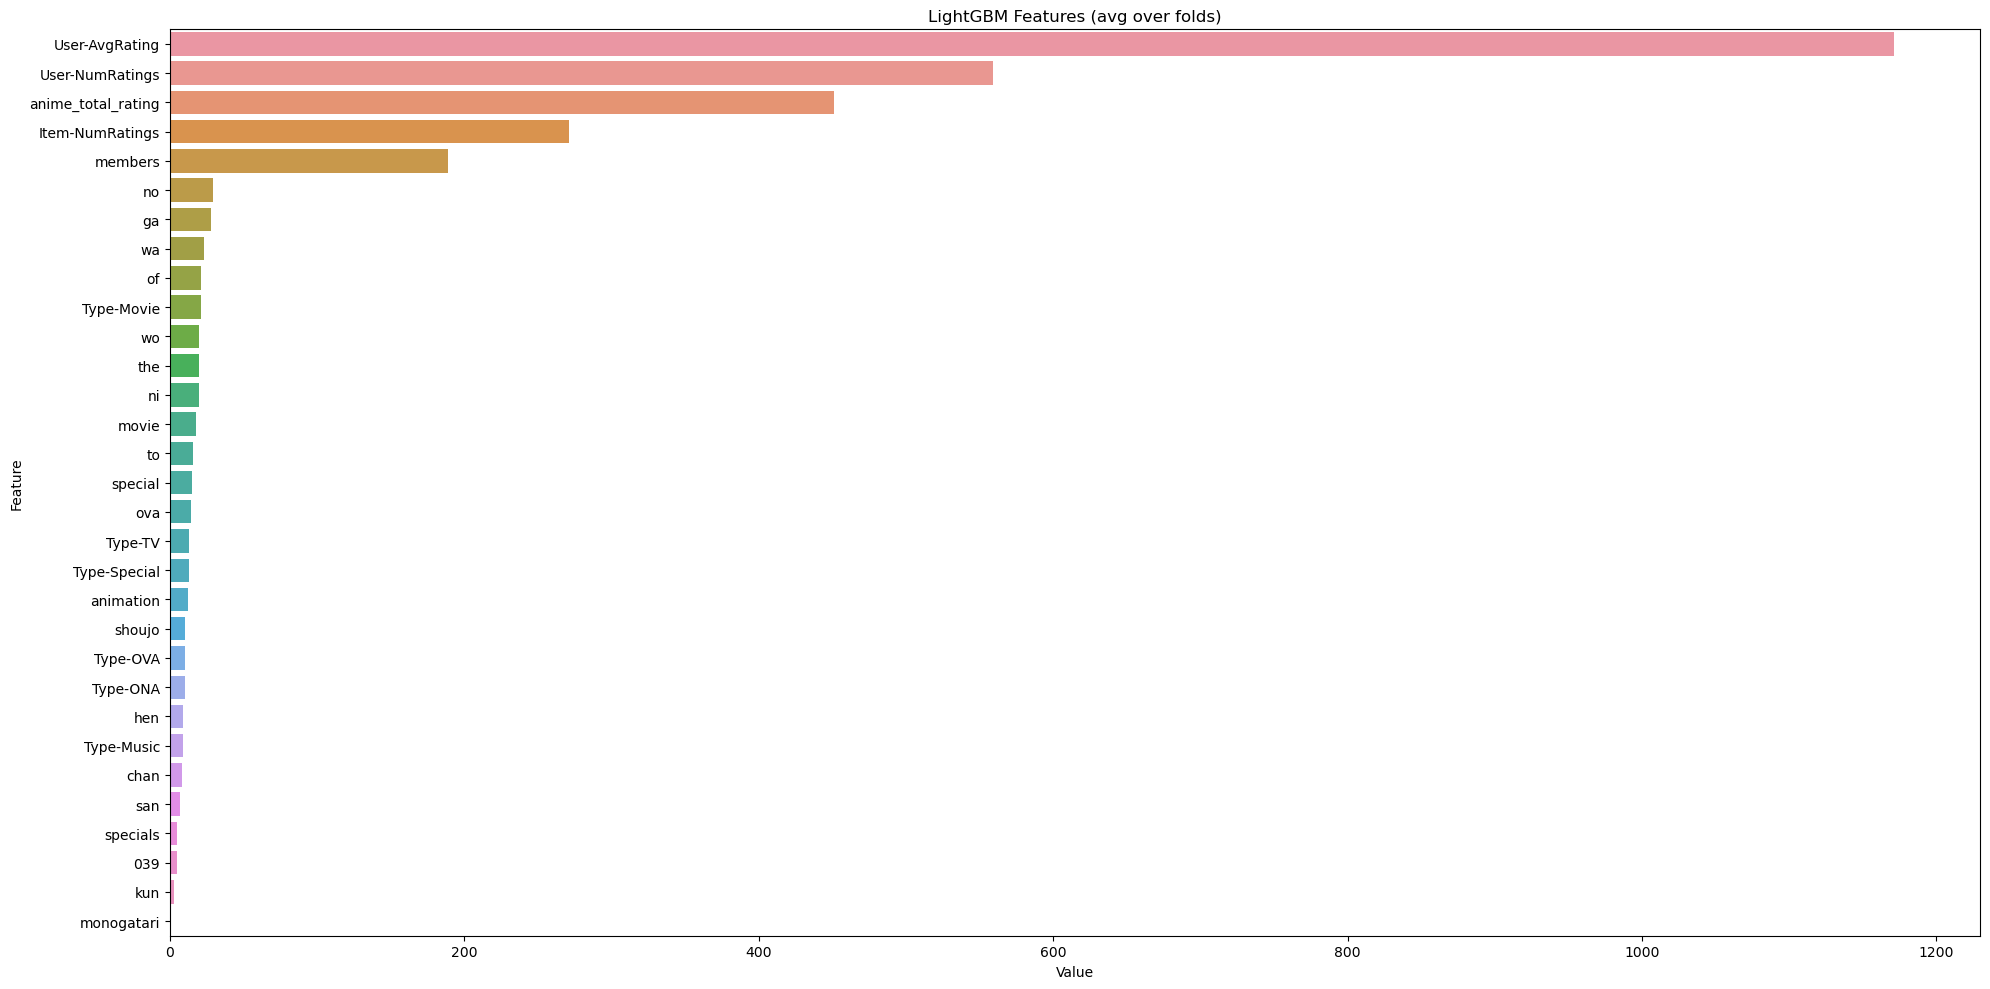

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# model = models['lgbm']

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

* Try things
    * hyper-params tuning
    * Feature engineering
        * genres / rating stats ....